In [94]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [95]:
data = pd.read_csv("../data/weather prediction/seattle-weather.csv")
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


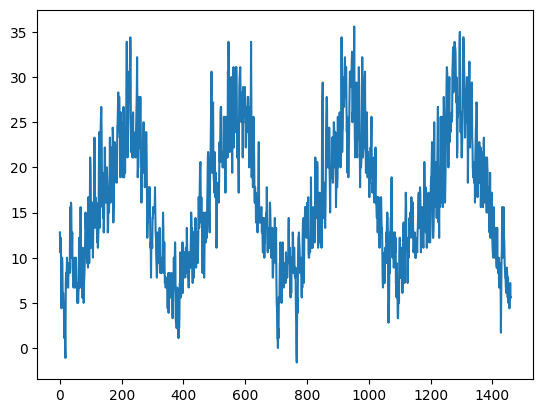

In [97]:
plt.plot(data["temp_max"])

In [122]:
data[["temp_max", "temp_min", "wind"]].values

array([[12.8,  5. ,  4.7],
       [10.6,  2.8,  4.5],
       [11.7,  7.2,  2.3],
       ...,
       [ 7.2,  0.6,  2.6],
       [ 5.6, -1. ,  3.4],
       [ 5.6, -2.1,  3.5]])

In [98]:
# 拆分数据集
temps = data["temp_max"]
train = temps[:-365].to_list()
test = temps[-365:].to_list()

In [99]:
# 自回归方式采样生成X, y
# 假设 根据前面n天气温,预测n+1天气温,n为采样窗口大小
def generate_data(data, window):
    days = len(data)
    X, y = [],[]
    for i in range(days-window):
        X.append(data[i:window+i])
        y.append(data[window+i])
    X, y = torch.tensor(X), torch.tensor(y)
    return X, y

X_trian, y_train = generate_data(train, 6)
X_test, y_test = generate_data(test, 6)
print(X_trian[:3])
print(y_train[:3])

tensor([[12.8000, 10.6000, 11.7000, 12.2000,  8.9000,  4.4000],
        [10.6000, 11.7000, 12.2000,  8.9000,  4.4000,  7.2000],
        [11.7000, 12.2000,  8.9000,  4.4000,  7.2000, 10.0000]])
tensor([ 7.2000, 10.0000,  9.4000])


In [100]:
import pickle
# # 任何对象以bit进行save, load
# with open("../data/weather.dat", "bw") as f:
#     pickle.dump(((X_trian, y_train),(X_test, y_test)), f)

In [101]:
class WeatherTemp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, X):
        output, _ = self.rnn(X)
        return self.fc(output[:,-1,:])
        pass


In [108]:
config = {
    "batch_size":1,
    "epoch":10,
    "lr":1e-4,
    "device":"cuda" if torch.cuda.is_available() else "cpu"
}


In [89]:
# 数据准备
with open("../data/weather.dat", "rb") as f:
    (X_trian, y_train),(X_test, y_test) = pickle.load(f)

In [115]:
ds_trian = list(zip(X_trian, y_train))
dl_trian = DataLoader(ds_trian, batch_size=config["batch_size"], shuffle=True)
model = WeatherTemp(1, 32)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
loss_fn = nn.MSELoss()
model = model.to(config["device"])
loss_fn = loss_fn.to(config["device"])


list

In [117]:
for epoch in range(config["epoch"]):
    process_bar = tqdm(dl_trian)
    model.train()
    total_loss = 0
    for X, y in process_bar:
        X, y = X.unsqueeze(-1).to(config["device"]), y.to(config["device"])
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        process_bar.set_description(f"epoch: {epoch + 1}, loss: {loss.item():.4f}")

epoch: 10, loss: 2.2149: 100%|██████████| 1090/1090 [00:03<00:00, 328.56it/s]  
